In [1]:
'''
Questions:

1. the scaled dot-product attention is using the mul or bmm (the dims of Q and K)
2. what if we remove the softmax function, the Q.K construct the attn_map and mul the value
3. if we're not the using the softmax layer, it can't restrict the value btw [0,1]
4. 

'''


"\nQuestions:\n\n1. the scaled dot-product attention is using the mul or bmm (the dims of Q and K)\n2. what if we remove the softmax function, the Q.K construct the attn_map and mul the value\n3. if we're not the using the softmax layer, it can't restrict the value btw [0,1]\n4. \n\n"

In [2]:
import torch
import torchtext
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from collections import defaultdict
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

%matplotlib inline

device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')

class args(object):
    
    model_name = 'Transformer' 
    model_path ='./'+ model_name +'/Model/'
    log_path = './'+ model_name +'/Log/' 

    
    ## Display
    valid_freq = 1
    valid_steps = 1
    plot_freq = 1
    save_freq = 1
    
    # Training
    batch_size = 5
    n_epoch = 5
    lr = 0.0002
    
    # Model
    softmax = True
    d_word_vec=512
    d_model=512
    d_inner=2048
    n_layers=6
    n_head=8
    d_k=64
    d_v=64
    dropout=0.1
    tgt_emb_prj_weight_sharing=True
    emb_src_tgt_weight_sharing=False
    
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)
if not os.path.exists(args.log_path):
    os.makedirs(args.log_path)
    
    
class Constants():
    
    PAD = 1
    UNK = 0
    SOS = 2
    EOS = 3

    PAD_WORD = '<blank>'
    UNK_WORD = '<UNK>'
    SOS_WORD = '<SOS>'
    EOS_WORD = '<EOS>'

In [3]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):

        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf) # and after the softmax layer, the attn will be 0

        if args.softmax:
            attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)

        return output, attn

class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()
        
        '''
        n_head: repeat multiple times
        '''

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size() # sz_b = batch_size
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # lk should be the same as lv
        # Question: lq = lk = lv ? 
        
        mask = mask.repeat(n_head, 1, 1) # (n*b) x .. x .. , what if the mask = None
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, d_v) # the output dim should be the same as v
        
        # d_k = d_v = d_model/ n_head = 64 
        # so n*d_v = d_model? trnasfer the dim back to d_model?
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)
        
        
        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual) 

        return output, attn

class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Conv1d(d_in, d_hid, 1) # position-wise --- input = (B, d_in, len) -> output = (B, d_hid, len)
        self.w_2 = nn.Conv1d(d_hid, d_in, 1) # position-wise --- input = (B, d_hid, hid) -> output = (B, d_in, len)
        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x # (B,L,C)
        output = x.transpose(1, 2) #(B,C,L)
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)
        return output

In [4]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output *= non_pad_mask

        enc_output = self.pos_ffn(enc_output)
        enc_output *= non_pad_mask

        return enc_output, enc_slf_attn


class DecoderLayer(nn.Module):
    ''' Compose with three layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, dec_input, enc_output, non_pad_mask=None, slf_attn_mask=None, dec_enc_attn_mask=None):
        
        '''
        enc_output will be included in this process,
        
        '''
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output *= non_pad_mask

        dec_output, dec_enc_attn = self.enc_attn( 
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask) # this one shouldn't be masked?
        dec_output *= non_pad_mask  

        dec_output = self.pos_ffn(dec_output)
        dec_output *= non_pad_mask

        # no Linear and a softmax layer at the end.
        
        return dec_output, dec_slf_attn, dec_enc_attn


In [5]:
def get_non_pad_mask(seq):
    assert seq.dim() == 2
    
    args.non_pad = seq.ne(Constants.PAD).type(torch.float).unsqueeze(-1)
    return seq.ne(Constants.PAD).type(torch.float).unsqueeze(-1)  # ne: a!=b 

def get_sinusoid_encoding_table(n_position, d_hid, padding_idx=None):
    ''' Sinusoid position encoding table '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)]) # n_position? 

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return torch.FloatTensor(sinusoid_table)

def get_attn_key_pad_mask(seq_k, seq_q):
    ''' For masking out the padding part of key sequence. '''

    # Expand to fit the shape of key query attention matrix.
    len_q = seq_q.size(1) # should I change this to 2?
    padding_mask = seq_k.eq(Constants.PAD) # find out the padding space. 
    padding_mask = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk # can I use repeat to place this?

    return padding_mask

def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    
    # why we get the mask by this way.
    
    # make sure that we only cosider the generated word before the target word.

    sz_b, len_s = seq.size()
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)
    subsequent_mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls
    args.subsequent_mask = subsequent_mask
    return subsequent_mask

class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self,
            n_src_vocab, len_max_seq, d_word_vec,
            n_layers, n_head, d_k, d_v,
            d_model, d_inner, dropout=0.1):

        super().__init__()

        n_position = len_max_seq + 1

        self.src_word_emb = nn.Embedding(
            n_src_vocab, d_word_vec, padding_idx=Constants.PAD)

        self.position_enc = nn.Embedding.from_pretrained(
            get_sinusoid_encoding_table(n_position, d_word_vec, padding_idx=1),
            freeze=True)

        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, src_seq,  return_attns=False):

        '''
        src_seq?
        src_pos? -> for positional embedding
        '''
        enc_slf_attn_list = []
        
        src_pos = self.get_positional_input(src_seq)
        # -- Prepare masks
        slf_attn_mask = get_attn_key_pad_mask(seq_k=src_seq, seq_q=src_seq) # seq_k = seq_q ? 
        non_pad_mask = get_non_pad_mask(src_seq) 

        # -- Forward # use two embedding layer for transform the input?
        
#         print('Source:' ,src_seq.shape)
#         print('Word:', self.src_word_emb(src_seq).shape)
#         print('Position: ',self.position_enc(src_pos).shape)
        enc_output = self.src_word_emb(src_seq) + self.position_enc(src_pos)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output,
                non_pad_mask=non_pad_mask,
                slf_attn_mask=slf_attn_mask)
            if return_attns:
                enc_slf_attn_list += [enc_slf_attn]

        if return_attns:
            return enc_output, enc_slf_attn_list  # what's the usage of the attention map?
        return enc_output,
    
    def get_positional_input(self, input_seq):
        
        B, S = input_seq.size()
        
        return torch.arange(S).unsqueeze(0).repeat(B,1).long()
    
    

class Decoder(nn.Module):
    ''' A decoder model with self attention mechanism. '''

    def __init__(
            self,
            n_tgt_vocab, len_max_seq, d_word_vec,
            n_layers, n_head, d_k, d_v,
            d_model, d_inner, dropout=0.1):

        super().__init__()
        n_position = len_max_seq + 1

        self.tgt_word_emb = nn.Embedding(
            n_tgt_vocab, d_word_vec, padding_idx=Constants.PAD)

        self.position_enc = nn.Embedding.from_pretrained(
            get_sinusoid_encoding_table(n_position, d_word_vec, padding_idx=1),
            freeze=True)

        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, tgt_seq, src_seq, enc_output, return_attns=False):
        
        '''
        tgt_seq? 
        
        tgt_pos? -> for positional embedding
        
        src_seq?
        
        '''

        dec_slf_attn_list, dec_enc_attn_list = [], []
        
        tgt_pos = self.get_positional_input(tgt_seq)

        # -- Prepare masks
        non_pad_mask = get_non_pad_mask(tgt_seq)

        slf_attn_mask_subseq = get_subsequent_mask(tgt_seq) # what's the meaning of having this mask? 
        slf_attn_mask_keypad = get_attn_key_pad_mask(seq_k=tgt_seq, seq_q=tgt_seq)
        slf_attn_mask = (slf_attn_mask_keypad + slf_attn_mask_subseq).gt(0) # greater than 0

        dec_enc_attn_mask = get_attn_key_pad_mask(seq_k = src_seq, seq_q = tgt_seq)

        # -- Forward
        dec_output = self.tgt_word_emb(tgt_seq) + self.position_enc(tgt_pos)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output,
                non_pad_mask=non_pad_mask,
                slf_attn_mask=slf_attn_mask,
                dec_enc_attn_mask=dec_enc_attn_mask)

            if return_attns:
                dec_slf_attn_list += [dec_slf_attn]
                dec_enc_attn_list += [dec_enc_attn]
        
        
        # the softmax is still not implemented in this function
        
        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        
        return dec_output,
    
    def get_positional_input(self, input_seq):
        
        B, S = input_seq.size()
        
        return torch.arange(S).unsqueeze(0).repeat(B,1).long()

class Transformer(nn.Module):
    ''' A sequence to sequence model with attention mechanism. '''

    def __init__(
            self,
            n_src_vocab, n_tgt_vocab, len_max_seq,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1,
            tgt_emb_prj_weight_sharing=True,
            emb_src_tgt_weight_sharing=False):
        
        # sharing weight of embedding layer?

        super().__init__()

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, len_max_seq=len_max_seq,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            dropout=dropout)

        self.decoder = Decoder(
            n_tgt_vocab=n_tgt_vocab, len_max_seq=len_max_seq,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            dropout=dropout)

        self.tgt_word_prj = nn.Linear(d_model, n_tgt_vocab, bias=False)
        nn.init.xavier_normal_(self.tgt_word_prj.weight)

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if tgt_emb_prj_weight_sharing:
            # Share the weight matrix between target word embedding & the final logit dense layer
            self.tgt_word_prj.weight = self.decoder.tgt_word_emb.weight
            self.x_logit_scale = (d_model ** -0.5)
        else:
            self.x_logit_scale = 1.

        if emb_src_tgt_weight_sharing:
            # Share the weight matrix between source & target word embeddings
            # but why do we need to share? they're from different language.
            assert n_src_vocab == n_tgt_vocab, \
            "To share word embedding table, the vocabulary size of src/tgt shall be the same."
            self.encoder.src_word_emb.weight = self.decoder.tgt_word_emb.weight
            
        self.train_hist = defaultdict(list) # should I still record the hist over here?
        # use T.train_hist to record history
        self.apply(self.weight_init)
        
    def forward(self, src_seq, tgt_seq):
        
        # where can I get the tgt_seq?

        tgt_seq = tgt_seq[:, :-1] # the reason of removing the last seq? A

        enc_output, *_ = self.encoder(src_seq)
        dec_output, *_ = self.decoder(tgt_seq, src_seq, enc_output)
        seq_logit = self.tgt_word_prj(dec_output) * self.x_logit_scale

        return seq_logit.view(-1, seq_logit.size(2)) # what's the shape of this output? 
    
    
    def get_loss(self, src_seq, trg_seq):
        
        gold = trg_seq[:,1:]
        
        pred = self.forward(src_seq, trg_seq)
        
        non_pad_mask = gold.contiguous().view(-1).ne(Constants.PAD)
        
        n_word_total = non_pad_mask.sum().item()
        
        # the loss without smoothing
        
        loss = Loss(pred, gold.contiguous().view(-1))/n_word_total # what if the len of the pred and the trg_seq are not the same? 
        
        pred = pred.max(1)[1]
        n_correct = pred.eq(gold.contiguous().view(-1))
        n_correct = n_correct.masked_select(non_pad_mask).sum()
        
        return loss, n_correct / n_word_total
    
    def plot_hist(self, key, hist, step, save = False, clean = False):
        
        if clean:
            clear_output(True)
        fig, ax = plt.subplots(figsize= (20,8))
        for name in hist.keys():
            if name.find(key) != -1: # check if the name has the keyword
                plt.plot(hist[name], label = name)
                plt.xlabel('Number of Steps',fontsize=15)
                plt.ylabel( key, fontsize=15)
                plt.title(key, fontsize=30, fontweight ="bold")
                plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        
        if save:
            fig.savefig(args.log_path+"Train_Hist_"+str(step)+".png")
    
    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
    
    def model_save(self, step):
        
        path = args.model_path + args.model_name + '_Step_' + str(step) + '.pth'
        torch.save({args.model_name: self.state_dict()}, path)
        
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        
        print('Model Loaded')
    
    def weight_init(self,m):
        
        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
            
            nn.init.kaiming_uniform_(m.weight, 0, nonlinearity='relu')
            
        elif type(m) in [nn.LSTM]:
            
            for name, value in m.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()


In [6]:
root = '../Data/multi30k/data/'

# torchtext.datasets.Multi30k.download(root)

DE = torchtext.data.Field(include_lengths=True,
           init_token='<sos>', eos_token='<eos>')
EN = torchtext.data.Field(include_lengths=True,
           init_token='<sos>', eos_token='<eos>')
# train, val, test = torchtext.datasets.Multi30k.splits(exts=('.de', '.en'), fields=(DE, EN), root = '../Data/multi30k/data')

train, val, test = torchtext.datasets.TranslationDataset.splits(      
      path = root,  
      exts = ['.de', '.en'],   
      fields = [('src', DE), ('trg', EN)],
      train = 'train', 
      validation = 'val', 
      test = 'test2016')
DE.build_vocab(train.src, min_freq=2)
EN.build_vocab(train.trg, max_size=10000)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
        (train, val, test), batch_size=args.batch_size, repeat=False)

# max_len = 0 
max_shape1 = 0 
for iterator in [train_iter, val_iter]:
    for i in iterator:
        for inst in [i.trg, i.src]:
            if inst[0].shape[0] > max_shape1:   
                max_shape1 = inst[0].shape[0]
#     if i.trg[1].max() > max_len:
#         max_len = i.trg[1].max().item()

/Users/richard/.virtualenvs/Richard/lib/python3.7/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths


In [7]:
T = Transformer(len(DE.vocab), len(EN.vocab),max_shape1,
                d_word_vec=args.d_word_vec, d_model=args.d_model, d_inner=args.d_inner,
                n_layers=args.n_layers, n_head=args.n_head, d_k=args.d_k, d_v=args.d_v, dropout= args.dropout,
                tgt_emb_prj_weight_sharing = args.tgt_emb_prj_weight_sharing,
                emb_src_tgt_weight_sharing = args.emb_src_tgt_weight_sharing) 

In [8]:
n_epoch = 0
optimizer = torch.optim.Adam(T.parameters(), lr = args.lr)
Loss = nn.CrossEntropyLoss(ignore_index=Constants.PAD, reduction='sum')

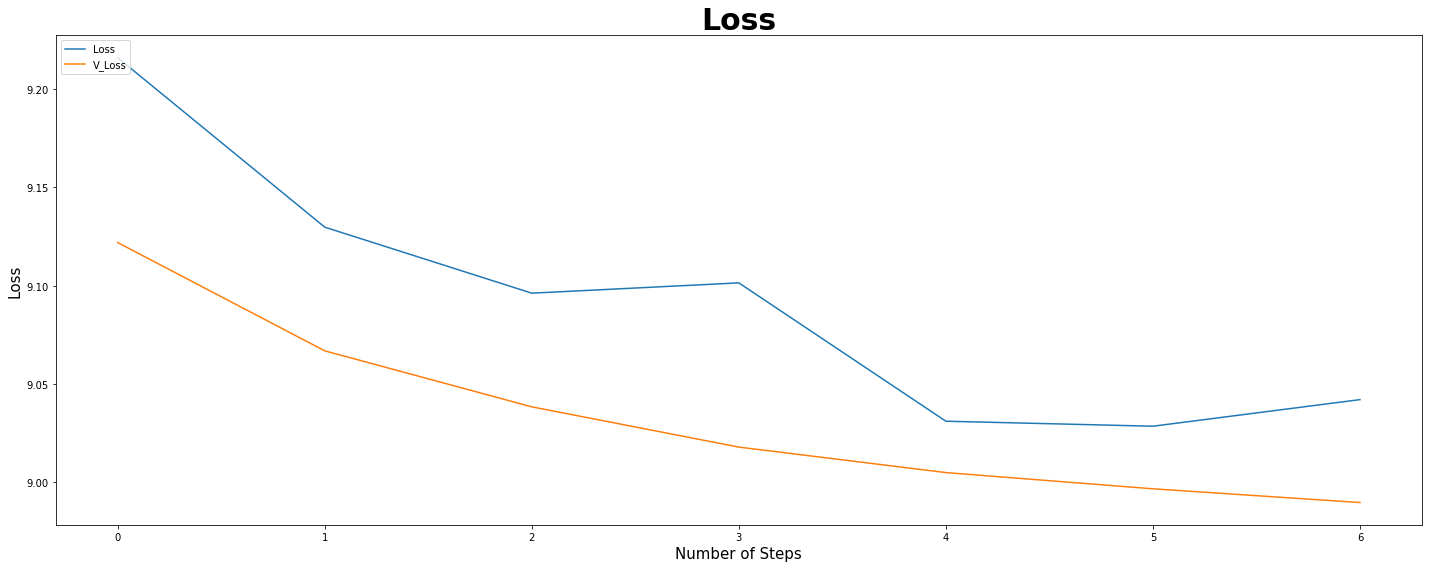

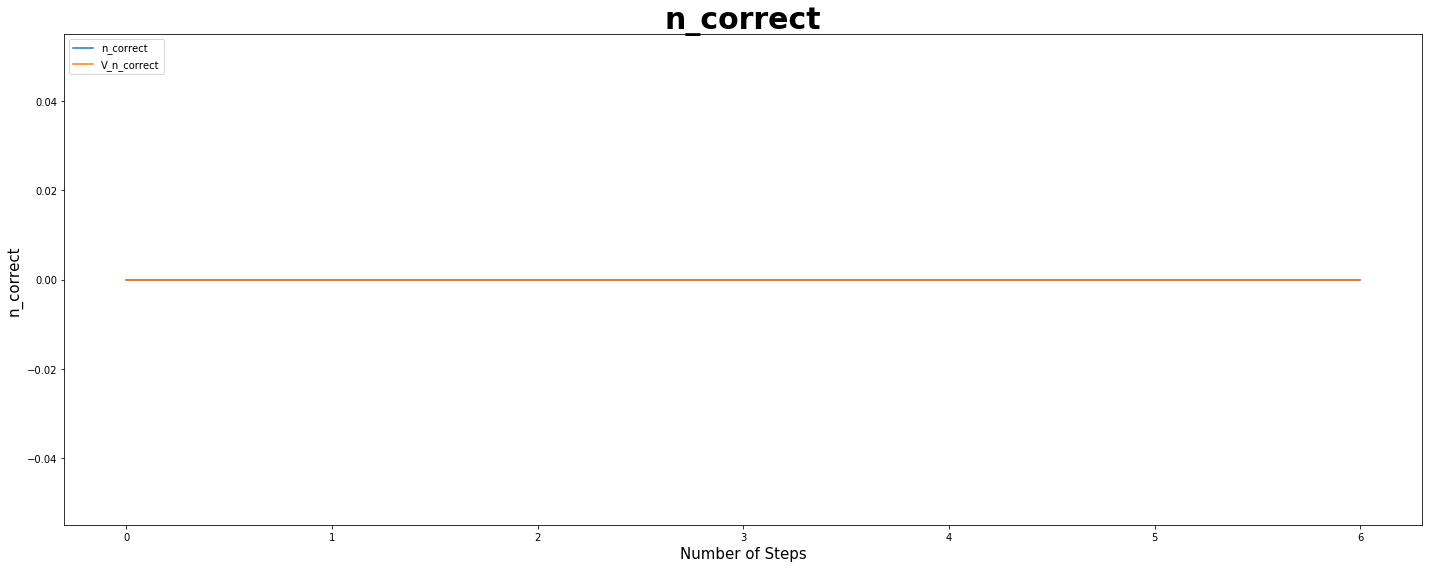

Model Saved


StopAsyncIteration: 

In [9]:
while n_epoch < args.n_epoch:
    
    for step, batch in enumerate(train_iter):
        
        T.train()
        
        optimizer.zero_grad()

        src_seq = batch.src[0].t().to(device)
        trg_seq = batch.trg[0].t().to(device)
        
        loss, n_correct = T.get_loss(src_seq, trg_seq)
        
        loss.backward()
        
        optimizer.step()

        
        T.train_hist['Loss'].append(loss.item())
        T.train_hist['n_correct'].append(n_correct.item())
        
            
        if step % args.valid_freq == 0:

            T.eval()
            
#             for _ in range(args.valid_steps):
                
            valid_batch = next(iter(val_iter))

            valid_src_seq = valid_batch.src[0].t().to(device)
            valid_trg_seq = valid_batch.trg[0].t().to(device)

            valid_loss, valid_n_correct = T.get_loss(valid_src_seq, valid_trg_seq)

            T.train_hist['V_Loss'].append(valid_loss.item())
            T.train_hist['V_n_correct'].append(valid_n_correct.item())
        else:
            # the info from the last data point.
            T.train_hist['V_Loss'].append(valid_loss.item())
            T.train_hist['V_n_correct'].append(valid_n_correct.item())
            plt.show()
        

        if step != 0 and step % args.plot_freq == 0 :
            
#             print('plotting')
            T.plot_hist('Loss', T.train_hist, 'Loss', save = True, clean = True)
            T.plot_hist('n_correct', T.train_hist, 'n_correct', save = True, clean = False)
            
            
        if step != 0 and step % args.save_freq == 0 :
            T.model_save('Training')
                
        if step > 5 :
            
            raise StopAsyncIteration
                
                
# save model point
# beam search
# translator and eval mode
        